Copyright **`(c)`** 2023 Arturo Adelfio `<arturo.adelfio@studenti.polito.it>`  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [106]:
from random import choices
from random import random, choice, randint
from dataclasses import dataclass
from copy import copy
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans
import math

import lab9_lib

## BEST PARAMETERS for Problem 1:
-POPULATION_SIZE: 100

-TOURNAMENT_SIZE = 2

-MUTATION_PROBABILITY = 0.01

-MIGRATION_PROBABILITY=0.01

-LOCI=1000

-num_islands=POPULATION_SIZE//10

-ISLAND_SIZE=POPULATION_SIZE//num_islands

-OFFSPRING_SIZE =ISLAND_SIZE//4


In [63]:
LOCI = 1000
POPULATION_SIZE = 30
OFFSPRING_SIZE = 20
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.15
GENERATIONS = 5000

is_removing=True

In [128]:

@dataclass
class Individual:
   
    fitness: float
    genotype: list[int]


    def __init__(self, fitness, genotype=None):
        if genotype is None:
            #genotype = list(choices([0, 1], k=LOCI))
            genotype=[choice((0, 1)) for _ in range(LOCI)]
        object.__setattr__(self, "_genotype", genotype)
        object.__setattr__(self, "_fitness", fitness(self.genotype))


    @property
    def genotype(self):
        return self._genotype

    @property
    def fitness(self):
        return self._fitness
      
    def __eq__(self, other):
        if isinstance(other, Individual):
            return self._genotype == other._genotype
        return False

    def __hash__(self):
        # Using hash() on a tuple of hashable attributes
        return hash(tuple(self._genotype))

def select_parent(pop):
    pool = [choice(pop) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion
    
def bit_flip_mutate(ind: Individual, fitness) -> Individual:
    """ bit-flip mutation """
    l=len(ind.genotype)
    
    p=MUTATION_PROBABILITY
    
    for i in range(l):
        if p>= np.random.normal():
            ind.genotype[i]=1-ind.genotype[i]
    
    return Individual(fitness, ind.genotype)

def mutate(ind: Individual,fitness) -> Individual:
    genotype=list(ind.genotype)
    index = randint(0, LOCI - 1)
    genotype[index] = 1 - genotype[index]
    return Individual(fitness=fitness, genotype=list(genotype))

def one_cut_xover(ind1: Individual, ind2: Individual, fitness) -> Individual:
    index = randint(0, LOCI - 1)
    offspring1 = Individual(fitness=fitness, genotype=list(ind1.genotype[:index]) + list(ind2.genotype[index:]))
    offspring2 = Individual(fitness=fitness, genotype=list(ind1.genotype[index:]) + list(ind2.genotype[:index]))
    #offspring2 = Individual(fitness=fitness, genotype=list(ind2.genotype[:index]) + list(ind1.genotype[index:]))

    return offspring1,offspring2

def two_cut_xover(ind1: Individual, ind2: Individual,fitness) -> Individual:
    cut_point_1= randint(0, LOCI-1)
    cut_point_2= randint(0, LOCI-1)

    if cut_point_1>cut_point_2:
        cut_point_1,cut_point_2=cut_point_2,cut_point_1

    if cut_point_1 != cut_point_2:
        ind1.genotype[cut_point_1::cut_point_2],ind2.genotype[cut_point_1::cut_point_2]=ind2.genotype[cut_point_1::cut_point_2],ind1.genotype[cut_point_1::cut_point_2]

    return Individual(fitness=fitness,genotype= list(ind1.genotype)),Individual(fitness=fitness,genotype= list(ind2.genotype))

def uniform_cut_xover(ind1: Individual, ind2: Individual,fitness) -> Individual:

    l=len(ind1.genotype)
    p=1/l
   
    for i in range(l):
    
        if p >=np.random.normal():
            ind1.genotype[i],ind2.genotype[i]=ind2.genotype[i],ind1.genotype[i]


    return Individual(fitness=fitness,genotype= list(ind1.genotype)),Individual(fitness=fitness,genotype= list(ind2.genotype))



In [129]:
def generation(population,crossover,fitness, mutation, mut_prob):
    
    offspring = list()

    for i in range(OFFSPRING_SIZE):
        if random() < mut_prob:  # self-adapt mutation probability
            p = select_parent(population)
            o = mutation(p, fitness)
            offspring.append(o)
        else:
            # xover 
            p1 = select_parent(population)
            p2 = select_parent(population)
            
            if crossover==one_cut_xover:
                o1,o2= one_cut_xover(p1, p2, fitness)
    
            elif crossover==two_cut_xover:
                o1,o2=two_cut_xover(p1,p2,fitness)
            else:
                o1,o2=uniform_cut_xover(p1,p2,fitness)
            if random() < mut_prob:  # self-adapt mutation probability
                o1 = mutate(o1, fitness)
                o2 = mutate(o2, fitness)
            
            offspring.append(o1)
            offspring.append(o2)
           
            i+=2
            

    #----------------remove previous duplicates------------
    if is_removing:
        population = list(set(population))    
    
    population.extend(offspring)
 
    population.sort(key=lambda i: i.fitness, reverse=True)
   
    population=population[:POPULATION_SIZE]

    best_fitness=population[0].fitness

    return best_fitness,population


## GA

In [109]:

def ga(problem_size):
    
    global MUTATION_PROBABILITY 
    fitness_func = lab9_lib.make_problem(problem_size)

    population = [
        Individual(fitness_func)
        for _ in range(POPULATION_SIZE)
    ]

    best_fitnesses=[]
    num_iterations=50000
    it=0
    new_fitness=0
    increasing=0
    decreasing=0

    for i in range(num_iterations):
        last_fitness=new_fitness
        it=i+1
        new_fitness, population= generation(population, one_cut_xover, fitness_func, mutate,0.15)
        best_fitnesses.append(new_fitness)
        if i%10==0:
           print("iteration",i, "fitness",new_fitness,"calls",fitness_func.calls)
        if new_fitness > last_fitness:
            increasing+=1
            if increasing>10 and MUTATION_PROBABILITY>0.01:
                increasing=0
                MUTATION_PROBABILITY*=0.8
        else:
            decreasing+=1
            if decreasing>10 and MUTATION_PROBABILITY<0.3:
                decreasing=0
                MUTATION_PROBABILITY*=1.05
                
        
        if new_fitness==1.0:
            break;

    plt.plot( range(0,it), best_fitnesses)
    plt.title("Problem size "+ str(problem_size) + " Genetic Algorithm, fitness calls: "+ str(fitness_func.calls))
    plt.xlabel("iterations")
    plt.ylabel("fitness") 
    plt.show()
    print("calls",fitness_func.calls) 

#-------------solve the problems 1 and 2 with a ga without islands------------------


In [ ]:
ga(1)

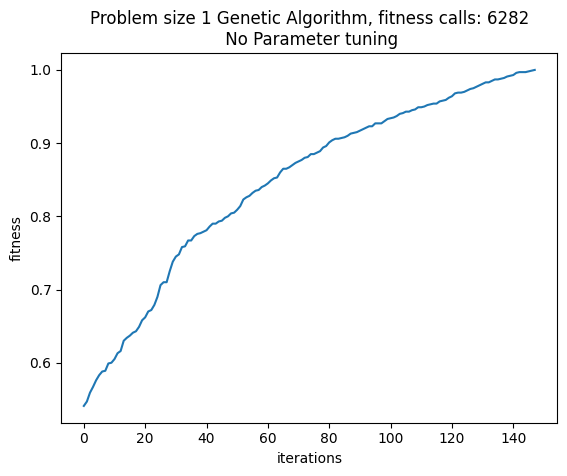
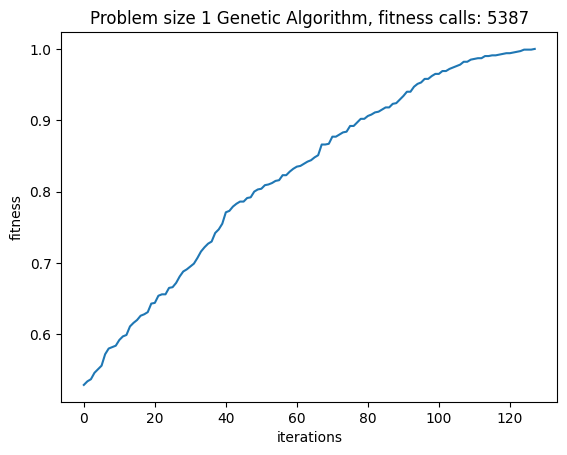

In [45]:
LOCI = 1000
POPULATION_SIZE = 30
OFFSPRING_SIZE = 20
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.15

is_removing=False

In [ ]:

ga(2)


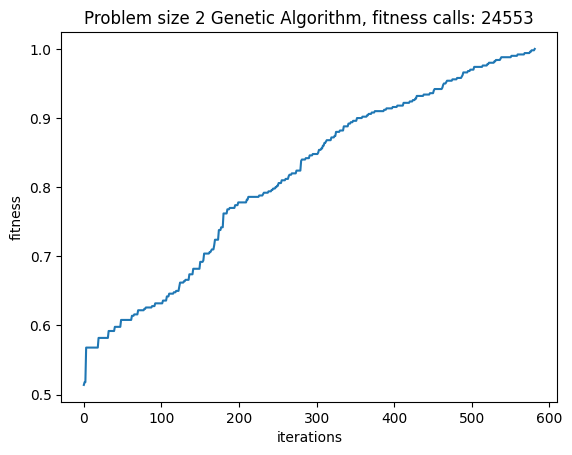

In [53]:
LOCI = 1000
POPULATION_SIZE = 50
OFFSPRING_SIZE = 30
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.10

is_removing=False

In [ ]:
ga(5)

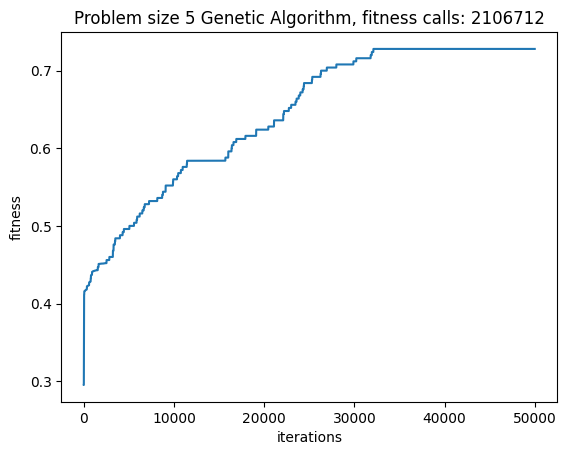
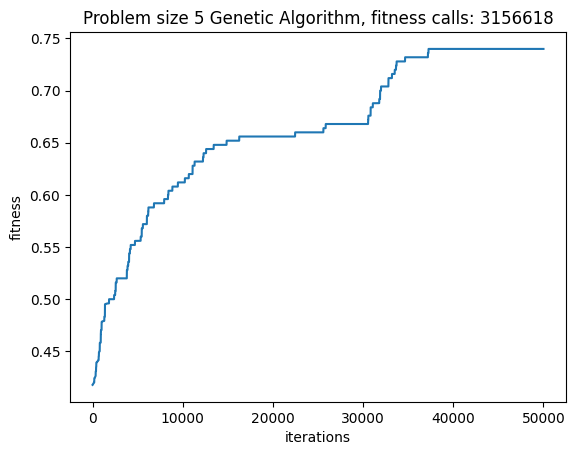

In [ ]:
ga(10)

## ISLANDS MODEL

In [123]:
ALL_POPULATION_SIZE = 500
TOURNAMENT_SIZE = 3
MUTATION_PROBABILITY = 0.001
MIGRATION_PROBABILITY=0.01
LOCI=1000
num_islands=5
POPULATION_SIZE=ALL_POPULATION_SIZE//num_islands
OFFSPRING_SIZE =POPULATION_SIZE//3*2
is_removing=True
print(POPULATION_SIZE) 
print(OFFSPRING_SIZE)

100
66


In [130]:
fitness_function=lab9_lib.make_problem(10)   

@dataclass
class Island:
    population: list[Individual]
    crossover: callable
    scale_factor: float


def migration(islands):
    #print(len(islands[0].population))
    migrants=[]
    num_migrants=10
    for i in range(len(islands)):
        for _ in range(num_migrants):
         
            if random()<0.5:
                migrant=max(islands[i].population, key=lambda x: x.fitness)
            else:
                migrant=choice(islands[i].population)
      
            islands[i].population.remove(migrant)
     
            migrants.append(migrant)

    for i in range (len(islands)):
        for j in range(len(migrants)):
            if i==0:
                islands[i].population.append(migrants[len(migrants)-j-1])
            else:
                islands[i].population.append(migrants[i*num_migrants-j-1])
                
    return islands



population = [
    Individual(fitness_function)
    for _ in range(ALL_POPULATION_SIZE)
]

islands=[]
#-----------------SIMILARITY COMPUTED VIA FITNESS ------------


# Create the islands with similar individual
population.sort(key=lambda i: i.fitness)
   
j=0
for i in range(0, len(population), POPULATION_SIZE):
    j+=1
    sublist = population[i:i + POPULATION_SIZE]
    prob= random()
    if prob<0.5:
        islands.append(Island(population=sublist, crossover=one_cut_xover, scale_factor=1.0))
   
    else:
        islands.append(Island(population=sublist, crossover=two_cut_xover, scale_factor=2.0))


"""
#------------SIMILARITY COMPUTED VIA CLUSTERING--------------------

# Convert the list to a NumPy array
data_array = np.array([individual.genotype for individual in population])

# Specify the number of clusters (you can adjust this based on your needs)
num_clusters = num_islands

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data_array)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Group binary vectors by cluster
clustered_data = {i: [] for i in range(num_clusters)}
for i, vector in enumerate(population):
    cluster_label = cluster_labels[i]
    clustered_data[cluster_label].append(vector)

# Print the result
for cluster_label, individuals in clustered_data.items():
    #print(f"Cluster {cluster_label + 1}: {[ind for ind in individuals]}")
    islands.append(Island(population=individuals, crossover=one_cut_xover, scale_factor=1.0))
    #print("len islands", len(islands))
"""
best_fitnesses=[0 for _ in range(num_islands)]
max_fitness=0
max_fitnesses=[]
calls=[]
it=0
same=0
last_fitness=0
increasing=0
decreasing=0

#while max_fitness!=1.0:
for i in range(30000):   
    
    last_fitness=max_fitness

    for j in range(len(islands)):
        
        best_fitnesses[j],islands[j].population = generation(islands[j].population,islands[j].crossover, fitness_function,bit_flip_mutate, islands[j].scale_factor*MUTATION_PROBABILITY)
        
    max_fitness=max(best_fitnesses)
    max_fitnesses.append(max_fitness)
    
    if i%10==0:
        print("iteration", i, "best ",  max_fitness)
        print("MUTATION",MUTATION_PROBABILITY)
        print("calls",fitness_function.calls)
        #print("MIGRATION", MIGRATION_PROBABILITY)

    if random()<MIGRATION_PROBABILITY:
        islands=migration(islands)
       
   
    if max_fitness > last_fitness:
        increasing+=1
        if increasing>30 and MUTATION_PROBABILITY>0.001:
            increasing=0
            MUTATION_PROBABILITY*=0.8
            MIGRATION_PROBABILITY*=0.8
    else:
        decreasing+=1
        if decreasing>20 and MUTATION_PROBABILITY<0.1:
            decreasing=0
            MUTATION_PROBABILITY*=1.05
            MIGRATION_PROBABILITY*=1.05

    if MUTATION_PROBABILITY>0.1:
        MUTATION_PROBABILITY*=0.75
        MIGRATION_PROBABILITY*=0.75
    
    it=i+1
    calls.append(fitness_function.calls)
    if max_fitness==1.0:
        break;
    #print(len(islands[0].population))
plt.plot( range(0,it), max_fitnesses)
plt.title("Problem 5 Island model, fitness calls: "+ str(fitness_function.calls))
plt.xlabel("iterations")
plt.ylabel("fitness") 
print("calls",fitness_function.calls) 

min indices  (82, 92)
Individual(fitness=0.049900114451000004, genotype=[1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 

KeyboardInterrupt: 

1549
calls 1026997


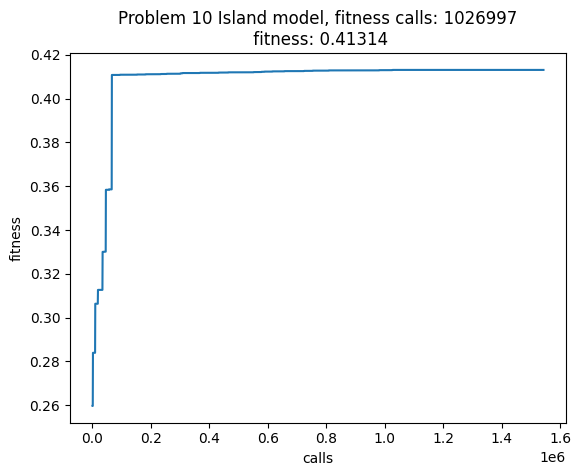

In [105]:

max_value=max(max_fitnesses)
ind=max_fitnesses.index(max_value)
print(ind)
#plt.plot( calls[0:ind], max_fitnesses[0:ind])
plt.plot( calls, max_fitnesses)
plt.title("Problem 10 Island model, fitness calls: "+ str(calls[ind]) +"\n fitness: "+str(max_value))
plt.xlabel("calls")
plt.ylabel("fitness") 
print("calls",calls[ind]) 

Clustering

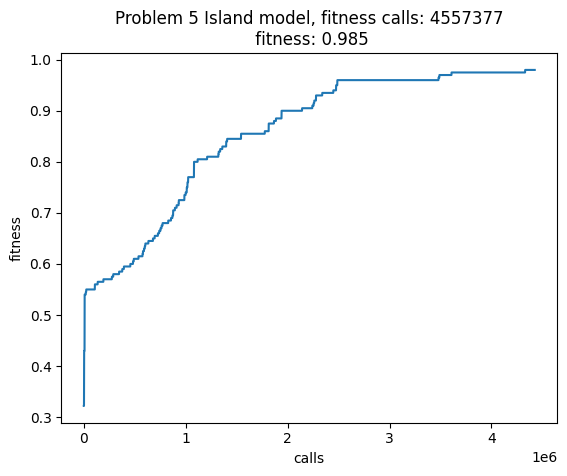

Similarity measured by Fitness

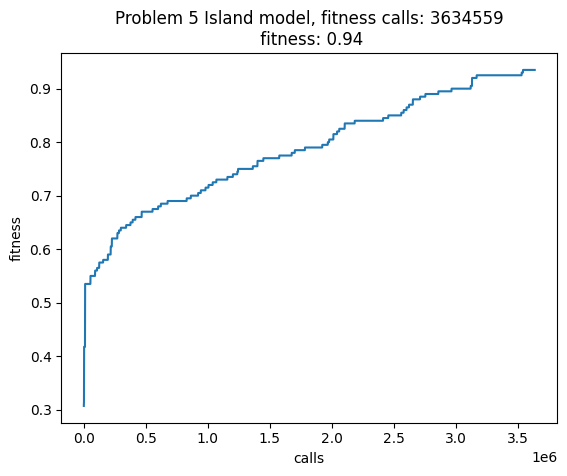

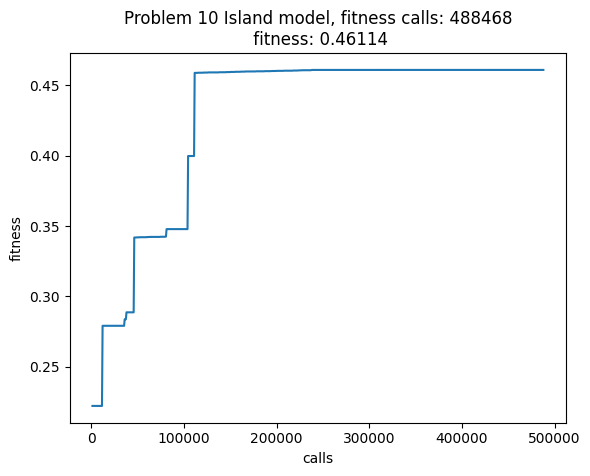

## HILL CLIMBING ( STEEPEST ASCENT )

In [ ]:
LOCI=1000
fitness_hc=lab9_lib.make_problem(10)

fitnesses=[]
calls=[]

def new_mutate(state:Individual, fitness)->Individual:
    #print("original ", state)

    individuals=[]
    
    for j in range (LOCI):
        gen=copy(state.genotype)
        gen[j]= 1-gen[j]
        individuals.append(Individual(fitness, genotype=gen))
        #print(individuals[j])
    return individuals

def hill_climbing():

    counter=0
    
    ended=False
    is_better=True
    not_improving=0
    current_state=Individual(fitness_hc)
    #new_state=current_state
    is_bitflip=False

    for _ in range(100000):

        counter+=1
       
        
        """ print("previous new state", new_state.fitness)
            not_improving=0
            new_state=mutate(new_state,fitness_hc)
            #current_state=new_state
            print("new new state", new_state.fitness)
            #print("new current state", current_state.fitness)
            continue
        """
       
        new_state = bit_flip_mutate(current_state,fitness_hc)
        """ if not_improving>50:
            not_improving=0
            new_state = max(new_mutate(current_state,fitness_hc), key=lambda x:x.fitness)

        elif is_bitflip:

            new_state = bit_flip_mutate(current_state,fitness_hc)
        
        else:
            new_state= mutate(current_state, fitness_hc) 
        """
        
        if current_state.fitness==1.0:
            ended=True
            break;

        is_better=new_state.fitness>current_state.fitness

        if is_better:
            not_improving=0
            current_state = new_state
            is_bitflip=False
        else:
            not_improving+=1
            is_bitflip=True

        calls.append(fitness_hc.calls)
        fitnesses.append(current_state.fitness)

        if counter%50==0:

            print("current ", current_state.fitness)
        
        #print("new", new_state.fitness)
        #print("calls", fitness_hc.calls)

    print( f"Solved in {counter:,} steps")
    print("final solution", current_state.fitness)


hill_climbing()
print(fitness_hc.calls)

In [ ]:

max_value=max(fitnesses)
ind=fitnesses.index(max_value)
#plt.plot(calls[0:ind+1], fitnesses[0:ind+1])
plt.plot(calls, fitnesses)
plt.title("Problem 10 hill climbing, "+ str(calls[ind]) +"\n fitness: "+str(max_value))
plt.xlabel("calls")
plt.ylabel("fitness") 
print("calls",calls[ind]) 